# 4. Use Case on Comparing Networks

Authors: **Gorka Zamora-López** and **Matthieu Gilson**

---------------------

This notebook is part of an introductory tutorial for the use of *Stimulus-Response Network Analysis* ([SiReNetA](https://github.com/mb-BCA/SiReNetA)) to study the structure of complex networks:
1. *[Getting Started and Overview](1_GettingStarted.ipynb)*
2. *[Calculating Response to Stimulus and Metrics](2_Basics_StimRespMetrics.ipynb)*
3. *[Canonical Models](3_Basics_CanonMods.ipynb)*
4. **[Comparing Networks](4_UseCase_CompareNets.ipynb)**
5. *[Network Distance](5_UseCase_NetDist.ipynb)*
6. *[Weighted Networks](6_UseCase_WeighteNets.ipynb)* 

---------------------

### Outline of use case
* Reproduce Fig 3 of [Zamora-López and Gilson (2024) Chaos](https://doi.org/10.1063/5.0202241)
* Show the equivalence between graph distance for discrete cascade and time-to-peak distance for leaky cascade for several binary graphs.
* 

---------------------

## Import libraries

In [1]:
try:
    import galib
except ImportError:
    %pip install git+https://github.com/gorkazl/pyGAlib.git@master    

In [2]:
# Python standard library imports
from timeit import default_timer as timer

# Third party imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg

import galib
import sireneta as sna

# Import local libraries


## 1. Properties of the original graphs (before normalization)

Write me here. Short introduction.


Begin by choosing the type of network to generate between three graph models:
- **Random**: Random graph of $G(N,L)$ class, with prespecified number of links.
- **Lattice**: A 1-dimensional ring lattice.
- **ScaleFree**: Random graph with scale-free-like degree distribution. For the small sizes here employed (N ≤ 500 nodes) the resulting degree distribution will be skewed but not fully scale-free.

In [3]:
netcase = 'Random'  # 'Random', 'Lattice', 'ScaleFree'

In [21]:
# Define the colors for plots later
cols = ['deepskyblue', '#1f77b4', 'red', '#d62728']

# Define the default scale for the plots
plt.rcParams['figure.dpi'] = 72

In [5]:
# Create four networks, combining two sizes and two density options
N1 = 200
N2 = 500
dens1 = 0.06
dens2 = 0.1
L1s = int(round( 0.5*dens1*N1*(N1-1) ))
L1d = int(round( 0.5*dens2*N1*(N1-1) ))
L2s = int(round( 0.5*dens1*N2*(N2-1) ))
L2d = int(round( 0.5*dens2*N2*(N2-1) ))

if netcase=='Random':
    net1 = galib.models.RandomGraph(N1, L1s).astype(float64)
    net2 = galib.models.RandomGraph(N1, L1d).astype(float64)
    net3 = galib.models.RandomGraph(N2, L2s).astype(float64)
    net4 = galib.models.RandomGraph(N2, L2d).astype(float64)
elif netcase=='Lattice':
    z1s = 6; z1d = 10
    z2s = 15; z2d = 25
    net1 = galib.models.Lattice1D(N1, z1s).astype(float64)
    net2 = galib.models.Lattice1D(N1, z1d).astype(float64)
    net3 = galib.models.Lattice1D(N2, z2s).astype(float64)
    net4 = galib.models.Lattice1D(N2, z2d).astype(float64)
elif netcase=='ScaleFree':
    net1 = galib.models.ScaleFreeGraph(N1, L1s).astype(float64)
    net2 = galib.models.ScaleFreeGraph(N1, L1d).astype(float64)
    net3 = galib.models.ScaleFreeGraph(N2, L2s).astype(float64)
    net4 = galib.models.ScaleFreeGraph(N2, L2d).astype(float64)

# Make sure the networks are connected
indeg1 = net1.sum(axis=0);  outdeg1 = net1.sum(axis=1)
indeg2 = net2.sum(axis=0);  outdeg2 = net2.sum(axis=1)
indeg3 = net3.sum(axis=0);  outdeg3 = net3.sum(axis=1)
indeg4 = net4.sum(axis=0);  outdeg4 = net4.sum(axis=1)
assert 0 not in [indeg1.min(), indeg2.min(), indeg3.min(), indeg4.min()], 'Disconnected graph found'


In [6]:
def SpectralRadius(eigenvalues):
    """Finds the eigenvalue with largest norm in the imaginary space."""
    
    N = len(eigenvalues)
    evnorms = np.zeros(N, float64)
    for i in range(N):
        evnorms[i] = numpy.linalg.norm(eigenvalues[i])
    maxradius = evnorms.max()

    return maxradius

In [8]:
# Compute the eigenvalues of the four networks
evs1 = numpy.linalg.eigvals(net1)
evs2 = numpy.linalg.eigvals(net2)
evs3 = numpy.linalg.eigvals(net3)
evs4 = numpy.linalg.eigvals(net4)
# Find the largest eigenvalues, and the corresponding critical τ for each network
evmax1 = SpectralRadius(evs1); taumax1 = 1.0 / evmax1
evmax2 = SpectralRadius(evs2); taumax2 = 1.0 / evmax2
evmax3 = SpectralRadius(evs3); taumax3 = 1.0 / evmax3
evmax4 = SpectralRadius(evs4); taumax4 = 1.0 / evmax4


# Print some feedback: spectral radius and corresponding critical 'tau's
print( '\tSpectral radius\tLargest tau' )
print( 'net #1:   %3.5f\t%2.5f'  %(evmax1, taumax1) )
print( 'net #2:   %3.5f\t%2.5f'  %(evmax2, taumax2) )
print( 'net #3:   %3.5f\t%2.5f'  %(evmax3, taumax3) )
print( 'net #4:   %3.5f\t%2.5f'  %(evmax4, taumax4) )


	Spectral radius	Largest tau
net #1:   13.03689	0.07671
net #2:   20.71524	0.04827
net #3:   30.88528	0.03238
net #4:   50.69495	0.01973


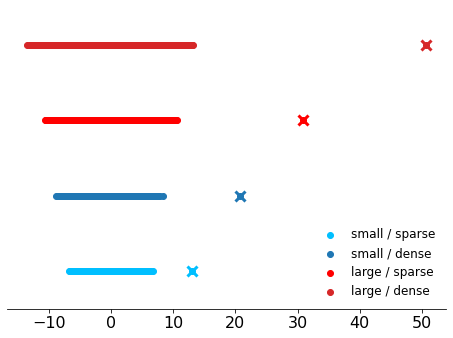

In [24]:
# Plot the eigenvalues of the four graphs
plt.figure()
ax = plt.axes()
ax.spines[['left','top','right']].set_visible(False)
ax.get_yaxis().set_visible(False)

plt.scatter(evs1.real, 0.01 + evs1.imag, c=cols[0], label='small / sparse')
plt.scatter(evs2.real, 0.02 + evs2.imag, c=cols[1], label='small / dense')
plt.scatter(evs3.real, 0.03 + evs3.imag, c=cols[2], label='large / sparse')
plt.scatter(evs4.real, 0.04 + evs4.imag, c=cols[3], label='large / dense')

plt.scatter(evmax1, 0.01, marker='x', s=100, lw=3, c=cols[0])
plt.scatter(evmax2, 0.02, marker='x', s=100, lw=3, c=cols[1])
plt.scatter(evmax3, 0.03, marker='x', s=100, lw=3, c=cols[2])
plt.scatter(evmax4, 0.04, marker='x', s=100, lw=3, c=cols[3])

plt.ylim(0.005,0.045)
plt.tick_params( labelsize=16 )

plt.legend(frameon=False, loc='lower right', fontsize=12)
plt.tight_layout()


In [25]:
# 1) COMPUTE THE DYNAMIC COMMUNICABILITY AND CALCULATE SOME PROPERTIES
# 1.1) Define the simulation parameters
# Define the temporal resolution
tfinal = 0.6
dt = 0.005
tpoints = arange(0.0, tfinal+0.1*dt, dt)
nsteps = len(tpoints)

# Set the decay time-constants τ, proportional to taumax
tauratio = 0.8
tau1 = tauratio * taumax1
tau2 = tauratio * taumax2
tau3 = tauratio * taumax3
tau4 = tauratio * taumax4

# Define the inputs to every node
stim = 1.0


In [26]:
# 1.3) Calculate the evolution of communicability over time for the nets
print('\nCalculating the dynamic communicability tensors from t=0 to t=%3.1f, with step=%3.3f ...' %(tfinal, dt) )
time1 = timer()
netresp1 = sna.Resp_LC(net1.T, tau=tau1, S0=stim, tmax=tfinal, timestep=dt, case='regressed')
netresp2 = sna.Resp_LC(net2.T, tau=tau2, S0=stim, tmax=tfinal, timestep=dt, case='regressed')
netresp3 = sna.Resp_LC(net3.T, tau=tau3, S0=stim, tmax=tfinal, timestep=dt, case='regressed')
netresp4 = sna.Resp_LC(net4.T, tau=tau4, S0=stim, tmax=tfinal, timestep=dt, case='regressed')
time2 = timer()
print( time2 - time1, 'seconds' )



Calculating the dynamic communicability tensors from t=0 to t=0.6, with step=0.005 ...
19.88539118999961 seconds


In [27]:
# 1.4) Compute the global network responses
# Sum of all pair-wise responses, at every time-point
globalresp1 = sna.GlobalResponse(netresp1)
globalresp2 = sna.GlobalResponse(netresp2)
globalresp3 = sna.GlobalResponse(netresp3)
globalresp4 = sna.GlobalResponse(netresp4)


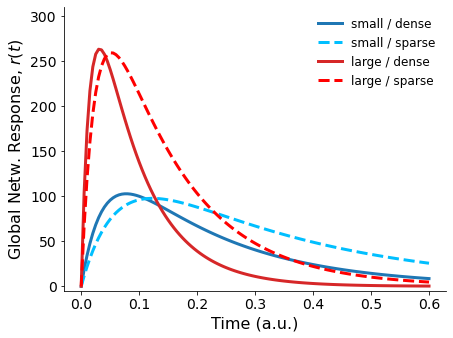

In [33]:
# Plot the global network responses
plt.figure()
ax = plt.axes()
ax.spines[['top','right']].set_visible(False)

plt.plot(tpoints, globalresp2, lw=3, c=cols[1],           label='small / dense')
plt.plot(tpoints, globalresp1, lw=3, c=cols[0], ls='--',  label='small / sparse')
plt.plot(tpoints, globalresp4, lw=3, c=cols[3],           label='large / dense')
plt.plot(tpoints, globalresp3, lw=3, c=cols[2], ls='--',  label='large / sparse')

plt.ylim(-5,310)
plt.tick_params( labelsize=14 )
plt.xlabel('Time (a.u.)', fontsize=16)
plt.ylabel('Global Netw. Response, $r(t)$', fontsize=16)

plt.legend(frameon=False, fontsize=12)
plt.tight_layout()


Write some brief explanations here …

In [36]:
# 1.4) Compare the (input) degrees to the node responses
noderesp1 = sna.NodeResponses(netresp1)[0]
noderesp2 = sna.NodeResponses(netresp2)[0]
noderesp3 = sna.NodeResponses(netresp3)[0]
noderesp4 = sna.NodeResponses(netresp4)[0]

# Integrate the response of every node over time
totnoderesp1 = sna.AreaUnderCurve(noderesp1, dt)
totnoderesp2 = sna.AreaUnderCurve(noderesp2, dt)
totnoderesp3 = sna.AreaUnderCurve(noderesp3, dt)
totnoderesp4 = sna.AreaUnderCurve(noderesp4, dt)


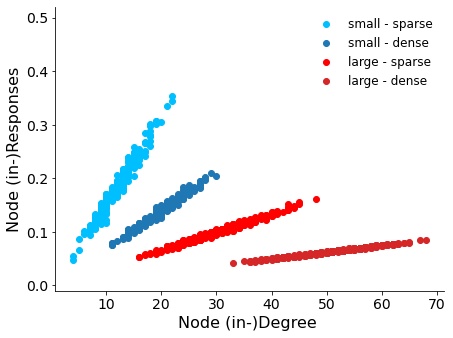

In [37]:
# Plot the (input) degree - node response relations
plt.figure()
ax = plt.axes()
ax.spines[['top','right']].set_visible(False)

plt.scatter(indeg1, totnoderesp1, c=cols[0], label='small - sparse')
plt.scatter(indeg2, totnoderesp2, c=cols[1], label='small - dense')
plt.scatter(indeg3, totnoderesp3, c=cols[2], label='large - sparse')
plt.scatter(indeg4, totnoderesp4, c=cols[3], label='large - dense')

plt.ylim(-0.01,0.52)
plt.tick_params( labelsize=14 )
plt.xlabel( 'Node (in-)Degree ', fontsize=16 )
plt.ylabel( 'Node (in-)Responses', fontsize=16 )

plt.legend( frameon=False, fontsize=12 )
plt.tight_layout()


Short description here.

## 2. Network properties after normalization

Brief explanation of normalization by λmax.

## 2. Comparison across models

Use precomputed results for Random, Lattice and ScaleFree to plot:

- Figure-1: GlobalResp of the three models withouth normalization.
- Figure-2: GlobalResp of the three models, after evmax normalization.
- Maybe show the node-wise responses as "imshow" ?